In [3]:
import gym
import random
import gym_gridworlds
import rlpa2
import mygrid
import sklearn
import numpy as np
enva = gym.make("gridenv-v0")
envb = gym.make("gridenv-v1")
envc = gym.make("gridenv-v2")

from collections import defaultdict
def sarsal(env,num_episodes,lamb,gamma = 0.9, alpha = 0.15, epsilon = 0.1):
    Q = defaultdict(lambda:np.zeros(4))
    E = defaultdict(lambda:np.zeros(4))
    env.reset()
#     env.render()
    Episodelen = []
    AvgReward = []
    for episode in range(num_episodes):
#         env.render()
        resetedpos = env.reset()
#         print("Start state",resetedpos)
        state = resetedpos
        rew = 0
        length = 0
        while(1):
            length+=1
            if(np.count_nonzero(Q[state])==0):
                bestaction = random.randint(0,3)
            else:
                bestaction = np.argmax(Q[state])
            prob_ba = 1.0 - epsilon + (epsilon/4)
            ba = random.uniform(0,1)
            Action_sel = -1
            if(ba<=prob_ba):
                Action_sel = bestaction
            else:
                t =random.randint(1,3)
                c =1
                for a in range(4):
                    if(a==bestaction):
                        continue
                    else:
                        if(c==t):
                            Action_sel = a
                            break
                        else:
                            c+=1
            next_state, reward,isT, _ = env.step(Action_sel)
            rew+=reward
            if(np.count_nonzero(Q[next_state])==0):
                best_n_action = random.randint(0,3)
            else:
                best_n_action = np.argmax(Q[next_state])
            prob_ba = 1.0 - epsilon + (epsilon/4)
            ba = random.uniform(0,1)
            Action_n_sel = -1
            if(ba<=prob_ba):
                Action_n_sel = best_n_action
            else:
                t =random.randint(1,3)
                c =1
                for a in range(4):
                    if(a==best_n_action):
                        continue
                    else:
                        if(c==t):
                            Action_n_sel = a
                            break
                        else:
                            c+=1
            delta = reward + gamma * Q[next_state][Action_n_sel] - Q[state][Action_sel]
            E[state][Action_sel]+=1
            
            for s,_ in Q.items() :
                Q[s][:] += alpha * delta * E[s][:]
                E[s][:] = gamma*lamb*E[s][:]
            if isT:
                break
            state = next_state
        AvgReward.append(rew)
        Episodelen.append(length)
    return AvgReward,Episodelen,Q

In [ ]:
#BELOW CODE IS TO CHANGE REWARD TO -0.01 to obtain Results FAST USED Only in case of SARSA(lambda)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
class GridWorld(object):
    def __init__(self,n=12,m=12):
        self.grid = np.zeros((m,n))
        self.m = m
        self.n = n
        self.n_actions = 4
        self.stateSpace = [i for i in range(self.m*self.n)]
        self.startstates = [60,72,120,132]
        self.startind = random.randint(0,3)
        self.agentposition = self.startstates[self.startind]
        ##Terminal state info say A
        self.stateSpace.remove(79)#A index
        self.stateSpaceplus = [i for i in range(self.m*self.n)]
        self.actionSpace = {'U':-self.n,'D':self.n,'L':-1,'R':1}
        self.possibleActions = ['U','D','L','R']
        #Rewards
        self.rewards  = np.zeros((m,n))
        
        for i in self.stateSpace:
            x = i // self.m
            y = i%self.n
            self.rewards[x][y]=-0.01
            if y in range(3,9):
                if y == 8:
                    if x in range(2,7):
                        self.rewards[x][y]-=1
                else:
                    if x in range(2,9):
                        self.rewards[x][y]-=1
            if y in range(4,8):
                if y == 7:
                    if x in range(3,6):
                        self.rewards[x][y]-=1
                else:
                    if x in range(3,8):
                        self.rewards[x][y]-=1
            if y in range(5,7):
                if y == 6:
                    if x==4:
                        self.rewards[x][y]-=1
                else:
                    if x in range(4,7):
                        self.rewards[x][y]-=1
        self.rewards[6][7]=10  #A reward
        self.setState(self.agentposition)
                    
                    
        
    def isTerminal(self,state):
        return state in self.stateSpaceplus and state not in self.stateSpace
    def getAgentRnC(self):
        x = self.agentposition // self.m
        y = self.agentposition % self.n
        return x,y
    def setState(self,state):
        x,y = self.getAgentRnC()
#         print(x)
#         print(y)
        self.grid[x][y]=-1
        self.agentposition = state
        x,y = self.getAgentRnC()
        self.grid[x][y]=1
    def offgrid(self,newState,oldState):
        if newState not in self.stateSpaceplus:
#             print("off")
            return True
        elif oldState % self.m == 0 and newState % self.m == self.m - 1:
            return True
        elif oldState % self.m == self.m-1 and newState % self.m == 0:
            return True
        else:
            return False
    def step(self,action):
        action = self.possibleActions[action]
        x,y = self.getAgentRnC()
        
        prob_w = random.uniform(0,1)
        wind = False
#         if(prob_w<=0.5):
#             wind = True
        #stoc = False
        prob_s = random.uniform(0,1)
        action_m = action
        if(prob_s<=0.9):
            action_m = action
        else:
            t = random.randint(1,3)
            c = 1
            for a in self.actionSpace:
                if(a==action):
                    continue
                else:
                    if(c==t):
                        action_m = a
                        break
                    c+=1
                
        resultingstate = self.agentposition + self.actionSpace[action_m]
        trans_state = 0
        reward = 0
        #here Reward will be after windapplication Think 
        #Say you got into terminal by moving west and wind blows you east you
        #remain in the same position
        if not self.offgrid(resultingstate,self.agentposition):
            trans_state = resultingstate
        else:
#             print("is off",resultingstate)
            trans_state = self.agentposition
#             print(trans_state)
#         if(wind):
#             result_wind = trans_state + self.actionSpace['R']
#             if not self.offgrid(result_wind,trans_state):
#                 trans_state = result_wind
#             else:
# #                 print("is off",result_wind)
#                 trans_state = trans_state
            
#                 print(trans_state)
        self.setState(trans_state)
        x_end = trans_state // self.m
        y_end = trans_state % self.n
        isT = self.isTerminal(self.agentposition)
#         print("state")
#         print(trans_state)
#         print(x_end)
#         print(y_end)
    
        return trans_state,self.rewards[x_end][y_end],isT,None
        
    def reset(self):
        self.grid = np.zeros((self.m,self.n))
        self.startind = random.randint(0,3)
        self.agentposition = self.startstates[self.startind]
        return self.agentposition
    def render(self):
        print('-----------------')
        for row in self.grid:
            for col in row:
                if col==0:
                    print('-',end =" ")
                elif col==1 or col==-1:
                    print('X',end =" ")
            print('\n')
        print('------------------')

In [10]:
en=GridWorld()

In [12]:
num_episode = 500
Q_sarsa = defaultdict(lambda:np.zeros(4))
r_sarsa = np.zeros(num_episode)
l_sarsa = np.zeros(num_episode)

num_runs = 50
smooth = 5
for i in range(num_runs):
    print(i)
    
    r,l,q = sarsal(en,num_episode,0.99)
    print("Max is ",np.max(l))
    for j in range(num_episode):
        r_sarsa[j]=(r_sarsa[j]*(i)+r[j])/(i+1)
        l_sarsa[j]=(l_sarsa[j]*(i)+l[j])/(i+1)
    for k in range(144):
        for a in range(4):
            Q_sarsa[k][a]=(Q_sarsa[k][a]*(i)+q[k][a])/(i+1)
        


0
Max is  2916
1
Max is  55645
2
Max is  9122
3
Max is  18328
4
Max is  8261
5
Max is  11574
6
Max is  7008
7
Max is  2611
8
Max is  5770
9
Max is  5145
10
Max is  65671
11
Max is  2792
12
Max is  2363
13
Max is  2728
14
Max is  5188
15
Max is  15117
16
Max is  17014
17
Max is  6633
18
Max is  8139
19
Max is  14276
20
Max is  1330
21
Max is  18504
22
Max is  16605
23
Max is  10728
24
Max is  3429
25
Max is  5503
26
Max is  47214
27
Max is  4869
28
Max is  1560
29
Max is  3442
30
Max is  3599
31
Max is  8839
32
Max is  6858
33
Max is  16025
34
Max is  12782
35
Max is  14578
36
Max is  11756
37
Max is  28731
38
Max is  4334
39
Max is  3873
40
Max is  8053
41
Max is  3702
42
Max is  3922
43
Max is  15972
44
Max is  4106
45
Max is  2856
46
Max is  5883
47
Max is  5908
48
Max is  6159
49
Max is  5801


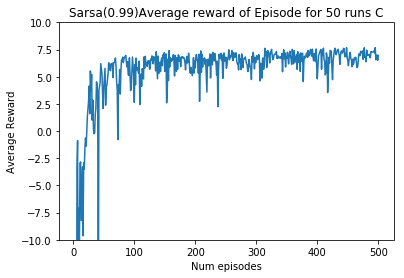

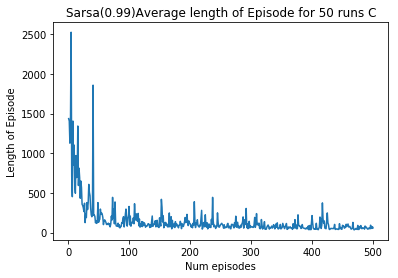

In [14]:
T = []
import matplotlib.pyplot as plt

# num_episode=100

for i in range(num_episode):
    T.append(i+1)
plt.title("Sarsa(0.99)Average reward of Episode for 50 runs C")
plt.xlabel("Num episodes")
plt.ylabel("Average Reward")
plt.ylim(-10,10)
plt.plot(T,r_sarsa)
plt.show()
plt.title("Sarsa(0.99)Average length of Episode for 50 runs C")
plt.xlabel("Num episodes")
plt.ylabel("Length of Episode")
plt.plot(T,l_sarsa)
plt.show()